! pip install notebook matplotlib ipywidgets jupyter tqdm tabulate numpy

In [ ]:
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed

%matplotlib inline

from datasets import (
  load_dataset,
)

dataset = load_dataset("stefantaubert/ljs-mos-120")
df_mos = dataset["train"].to_pandas()
df_mos["audio"] = df_mos["audio"].apply(lambda x: x["path"])

gt_files = sorted(df_mos[df_mos["condition"] == "gt"]["audio"].unique())
impl_files = sorted(df_mos[df_mos["condition"] == "impl"]["audio"].unique())
expl_files = sorted(df_mos[df_mos["condition"] == "expl"]["audio"].unique())

Resolving data files:   0%|          | 0/481 [00:00<?, ?it/s]

In [ ]:
from typing import List

import matplotlib.pyplot as plt
from mel_cepstral_distance.computation import *
from mel_cepstral_distance.helper import *
from mel_cepstral_distance.silence import *
from mel_cepstral_distance import get_amplitude_spectrogram, get_mel_spectrogram
#from tqdm.notebook import trange, tqdm # doesn't work
from tqdm import tqdm

PARAM_S = "s"
PARAM_D = "D"
PARAM_SAMPLE_RATE = "sample_rate"
PARAM_ALIGN_TARGET = "align_target"
PARAM_ALIGN_METHOD = "align_method"
PARAM_REMOVE_SILENCE = "remove_silence"
PARAM_SILENCE_THRESHOLD_A = "silence_threshold_A"
PARAM_SILENCE_THRESHOLD_B = "silence_threshold_B"
PARAM_DTW_RADIUS = "dtw_radius"
PARAM_FMAX = "fmax"
PARAM_FMIN = "fmin"
PARAM_N_FFT = "n_fft"
PARAM_M = "M"
PARAM_HOP_LEN = "hop_len"
PARAM_WIN_LEN = "win_len"
PARAM_WINDOW = "window"
PARAM_NORM_AUDIO = "norm_audio"
PARAM_EXPERIMENT_NAME = "experiment_name"

PARAMS_PROTOTYPE = {
  PARAM_EXPERIMENT_NAME: "default",  # does not count to cache
  PARAM_SAMPLE_RATE: 96000,
  PARAM_N_FFT: 128,
  PARAM_WIN_LEN: 128,
  PARAM_HOP_LEN: 32,
  PARAM_WINDOW: "hanning",
  PARAM_FMIN: 0,
  PARAM_FMAX: 48000,
  PARAM_M: 20,
  PARAM_S: 1,
  PARAM_D: 16,
  PARAM_ALIGN_METHOD: "dtw",
  PARAM_ALIGN_TARGET: "mfcc",
  PARAM_REMOVE_SILENCE: "no",
  PARAM_SILENCE_THRESHOLD_A: None,
  PARAM_SILENCE_THRESHOLD_B: None,
  PARAM_NORM_AUDIO: True,
  PARAM_DTW_RADIUS: 10,
}

def get_mels_mp(wavs, multicore=True):
  results = []
  
  jobs: List[Tuple] = []
  for file in wavs:
    jobs.append(
      (
        file,
        PARAMS_PROTOTYPE
      )
    )
    
  if multicore:
    with ProcessPoolExecutor() as executor:
      futures = [executor.submit(run_job, args) for args in jobs]
      for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

  else:
    # Führe sequentiell aus
    for job in tqdm(jobs, desc="Processing jobs"):
      result = run_job(job)
      results.append(result)
  return results


def run_job(args):
  return get_mel_spec(*args)

def get_mel_spec(wav, params):
  amp_spec = get_amplitude_spectrogram(
    wav,
    sample_rate=params[PARAM_SAMPLE_RATE],
    n_fft=params[PARAM_N_FFT],
    win_len=params[PARAM_WIN_LEN],
    hop_len=params[PARAM_HOP_LEN],
    window=params[PARAM_WINDOW],
    norm_audio=params[PARAM_NORM_AUDIO],
    remove_silence=False,
    silence_threshold=None,
  )
  X_kn = get_mel_spectrogram(amp_spec,
    params[PARAM_SAMPLE_RATE],
    params[PARAM_N_FFT],
    M=params[PARAM_M],
    fmin=params[PARAM_FMIN],
    fmax=params[PARAM_FMAX],
    remove_silence=False,
    silence_threshold = None,
  )
  return X_kn
  

def plot_all_energy_histograms_ljs(mels: list):
  energy_vals = []
  for X_kn in tqdm(mels):
    x_bel = get_loudness_vals_X_kn(X_kn)
    energy_vals.extend(x_bel)
 
  fig, ax = plt.subplots(1, 1)
  
  bins = 200
  width = 0.005

  ax.hist(energy_vals, bins=bins, edgecolor='black', color="black", density=True, width=width)

  ax.set_xlabel('Average energy [dB]')
  ax.set_ylabel('Distribution [%]')
  ax.set_title("")

  ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

  fig.suptitle("Energy distribution across Mel-spectrograms", style="italic")

  return fig

ALL_GT_MELS: list = None
ALL_IMPL_MELS: list = None
ALL_EXPL_MELS: list = None

def get_all_specs():
  logger = logging.getLogger("mel_cepstral_distance")
  logger.setLevel(logging.ERROR)
  
  global ALL_GT_MELS
  ALL_GT_MELS = get_mels_mp(gt_files, multicore=True)
  
  global ALL_IMPL_MELS
  ALL_IMPL_MELS = get_mels_mp(impl_files, multicore=True)
  
  global ALL_EXPL_MELS
  ALL_EXPL_MELS = get_mels_mp(expl_files, multicore=True)

get_all_specs()

100%|██████████| 120/120 [00:05<00:00, 20.09it/s]


100%|██████████| 120/120 [00:00<00:00, 48104.41it/s]


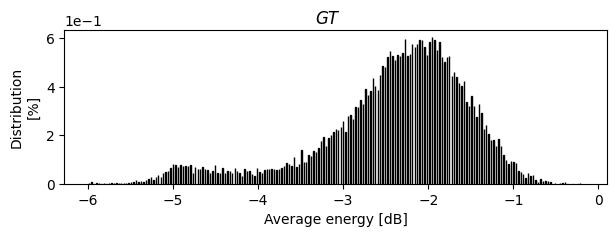

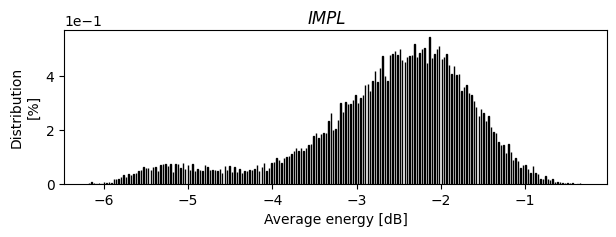

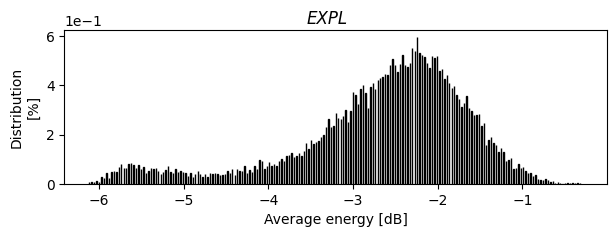

In [ ]:
def plot_all_specs():
  global ALL_GT_MELS
  fig = plot_all_energy_histograms_ljs(ALL_GT_MELS)
  fig.suptitle("GT")
  plt.gcf().set_size_inches(7,2)
  
  fig = plot_all_energy_histograms_ljs(ALL_IMPL_MELS)
  fig.suptitle("IMPL")
  plt.gcf().set_size_inches(7,2)
  
  global ALL_EXPL_MELS
  fig = plot_all_energy_histograms_ljs(ALL_EXPL_MELS)
  fig.suptitle("EXPL")
  plt.gcf().set_size_inches(7,2)

plot_all_specs()

77
GT -3.5


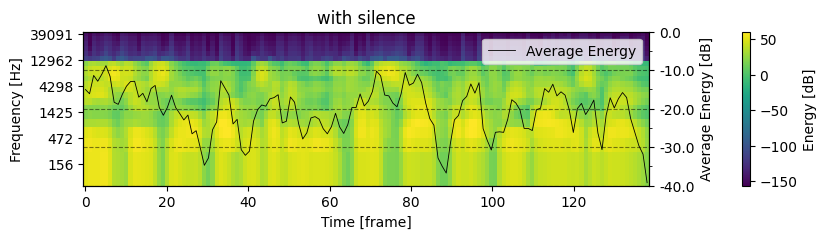

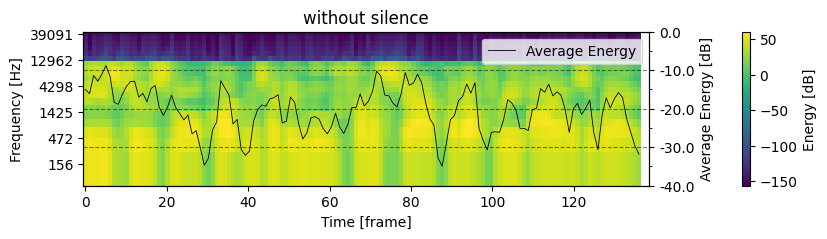

IMPL -4


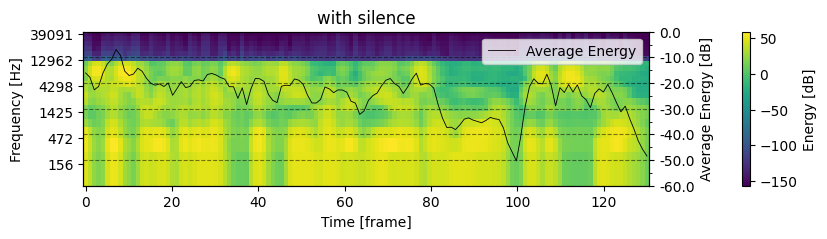

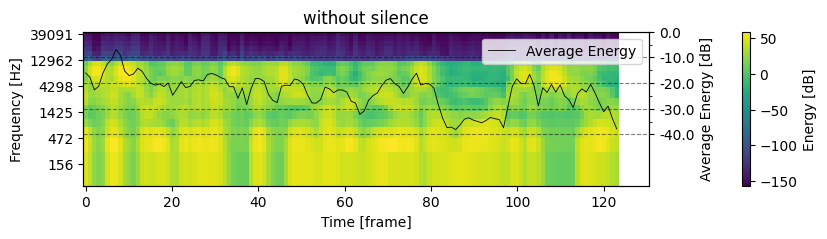

EXPL -4


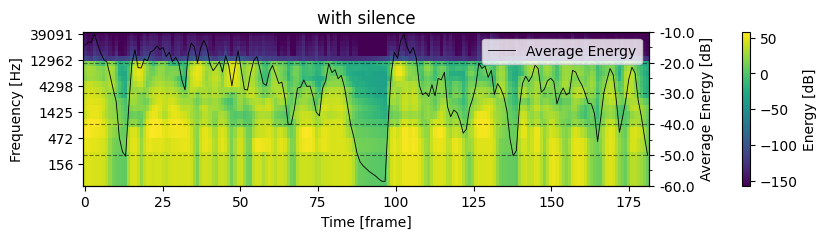

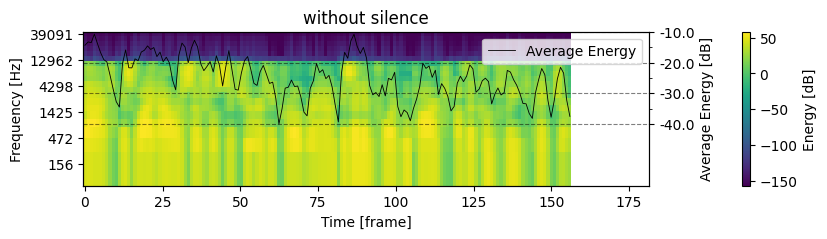

In [7]:
from mel_cepstral_distance_analysis.helper import plot_X_kn


def test_mel_silence_removal(X_kn, threshold_bel: float):
  fig1 = plot_X_kn(X_kn,  fmin=PARAMS_PROTOTYPE[PARAM_FMIN],
    fmax=PARAMS_PROTOTYPE[PARAM_FMAX],title="with silence")
  plt.gcf().set_size_inches(10,2)
  plt.show()

  X_kn = remove_silence_X_kn(X_kn, threshold_bel)

  fig2 = plot_X_kn(X_kn,  fmin=PARAMS_PROTOTYPE[PARAM_FMIN],
    fmax=PARAMS_PROTOTYPE[PARAM_FMAX],title="without silence")
  fig2.axes[0].set_ylim([fig1.axes[0].get_ylim()[0], fig1.axes[0].get_ylim()[1]])
  fig2.axes[1].set_ylim([fig1.axes[1].get_ylim()[0], fig1.axes[1].get_ylim()[1]])
  fig2.axes[0].set_xlim([fig1.axes[0].get_xlim()[0], fig1.axes[0].get_xlim()[1]])
  plt.gcf().set_size_inches(10,2)
  plt.show()


def plot_examples(idx: int):
  global ALL_GT_MELS
  global ALL_IMPL_MELS
  global ALL_EXPL_MELS

  threshold = -3.5
  print(f"GT {threshold}")
  test_mel_silence_removal(ALL_GT_MELS[idx], threshold)
  threshold = -4
  print(f"IMPL {threshold}")
  test_mel_silence_removal(ALL_IMPL_MELS[idx], threshold)
  threshold = -4
  print(f"EXPL {threshold}")
  test_mel_silence_removal(ALL_EXPL_MELS[idx], threshold)
  

if __name__ == "__main__":
  import random as rand
  
  global ALL_GT_MELS
  idx = rand.randint(0, len(ALL_GT_MELS))
  print(idx)
  plot_examples(idx)